In [1]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
# Load and preprocess MNIST data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
fraction = 0.2
train_size = int(len(X_train) * fraction)
test_size = int(len(X_test) * fraction)

# Shuffle and take a subset
np.random.seed(42)  # For reproducibility
train_indices = np.random.choice(len(X_train), train_size, replace=False)
test_indices = np.random.choice(len(X_test), test_size, replace=False)

In [3]:
y_train_encoded = to_categorical(y_train, 10)
y_test_encoded = to_categorical(y_test, 10)

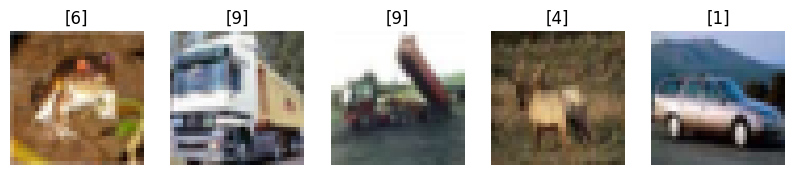

In [4]:
def display_samples(images, labels, num_samples=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

# Display a few training samples
display_samples(X_train, y_train, num_samples=5)

In [5]:
def build_transfer_model(base_model, neurons=128, dropout_rate=0.3):
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(neurons, activation='relu'),
        Dropout(dropout_rate),
        Dense(10, activation='softmax')  # 10 classes for CIFAR-10
    ])
    return model

In [6]:
from tensorflow.keras.applications import VGG16, ResNet50

experiments = [
    (VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3)), 'VGG16'),
    (ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3)), 'ResNet50')
]

In [7]:
def compile_and_train(model, learning_rate, batch_size, epochs=5):
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), epochs=epochs, batch_size=batch_size, verbose=1)
    return history

In [8]:
def plot_metrics(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Accuracy')
    ax2.legend()
    plt.show()

# Experiment configurations
configs = [(0.001, 32, 128), (0.0005, 64, 64)]


Evaluating VGG16


learning_rate=0.001, batch_size=32, neurons=128
Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 719s 458ms/step - accuracy: 0.3101 - loss: 4.3988 - val_accuracy: 0.5051 - val_loss: 1.4322
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 691s 442ms/step - accuracy: 0.4765 - loss: 1.4997 - val_accuracy: 0.5627 - val_loss: 1.2892
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 664s 425ms/step - accuracy: 0.5313 - loss: 1.3494 - val_accuracy: 0.5780 - val_loss: 1.2418
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 658s 421ms/step - accuracy: 0.5547 - loss: 1.2941 - val_accuracy: 0.5884 - val_loss: 1.2159
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 643s 412ms/step - accuracy: 0.5653 - loss: 1.2526 - val_accuracy: 0.5923 - val_loss: 1.2138


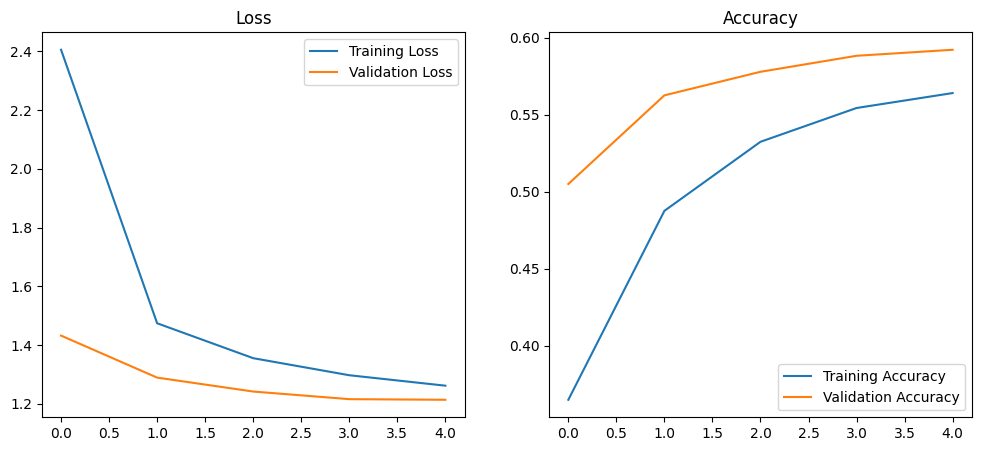

Test Loss: 1.2138, Test Accuracy: 0.5923


learning_rate=0.0005, batch_size=64, neurons=64
Epoch 1/5
367/782 ━━━━━━━━━━━━━━━━━━━━ 8:47 1s/step - accuracy: 0.2006 - loss: 11.7235

KeyboardInterrupt: 

In [9]:
for base_model, model_name in experiments:
    print(f"\nEvaluating {model_name}\n")
    for lr, batch, neurons in configs:
        print(f"\nlearning_rate={lr}, batch_size={batch}, neurons={neurons}")
        model = build_transfer_model(base_model, neurons=neurons)
        history = compile_and_train(model, learning_rate=lr, batch_size=batch)
        plot_metrics(history)
        test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}\n")

In [10]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True

model = build_transfer_model(base_model, neurons=128)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), epochs=5, batch_size=32, verbose=1)

test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch 1/5


KeyboardInterrupt: 

313/313 ━━━━━━━━━━━━━━━━━━━━ 133s 424ms/step
Confusion Matrix:
[[  3 705  27   4  46  24  25  84   0  82]
 [ 25 536  25  17  64 113 154  16   3  47]
 [ 24 656  38   3  33  57  94  38   2  55]
 [ 38 560  71   3  69  91  98  23   2  45]
 [ 74 523  16   1  80 148  51  13   4  90]
 [ 10 640  48   3  26  74 121  50   0  28]
 [ 33 591  25   0  69 132  78  26   5  41]
 [ 45 664  45   6  46  83  56  29   7  19]
 [ 14 509  46   6  79  73  97  15   0 161]
 [ 43 511  31  27  64 189  67  17   1  50]]


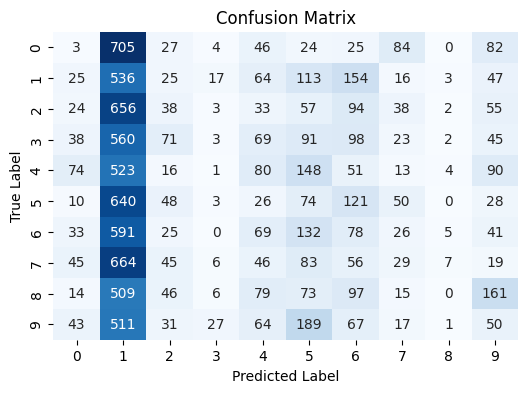

In [11]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show() 